# Analysis Report
In this notebook you'll find a report on the time series of the Italian Power load, as recorded by Terna, the Transmission System Operator  
Loads are recorded in MWh

## Overall info

In [95]:
import pandas as pd
power_load_df = pd.read_csv("../datasets/italian-power-load/load.csv")
power_load_df.Date = pd.to_datetime(power_load_df.Date)
print(f"Min date: {power_load_df.Date.min()}; Max date: {power_load_df.Date.max()}")
print(f"Nulls: {power_load_df.isnull().sum().sum()}")
print(f"Min Load: {power_load_df.Load.min():,.2f}; Max Load: {power_load_df.Load.max():,.2f}")

Min date: 2006-01-01 00:00:00; Max date: 2022-02-07 00:00:00
Nulls: 0
Min Load: 458,751.85; Max Load: 1,188,554.00


We have data from January 1st 2006, to February 7th 2022. The data seems to be very clean, without missing information, and the maximum consumption reached in this period was of 1,188,554.00 MWh, while the minimum was 458,751.85 MWh.

We can see the entire time series (altough a bit smooshed) here:

<Axes: xlabel='Date'>

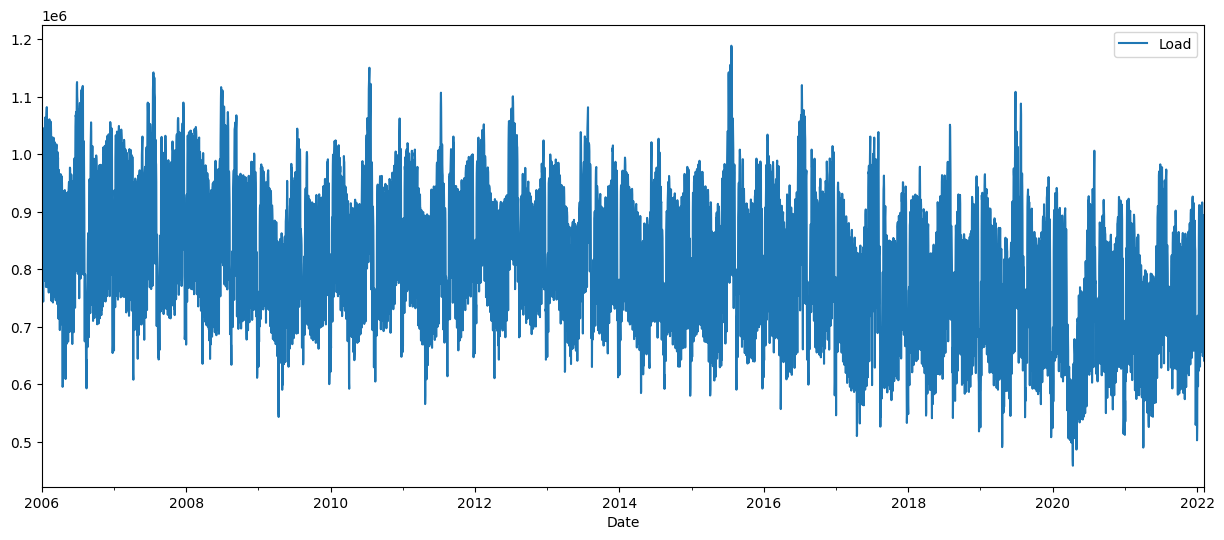

In [8]:
power_load_df.plot(x='Date',y='Load',kind='line',figsize=(15,6))

We can see there are repetitive patterns along the way, and a surprising and unusual behaviour in 2020 where consumption sees to be much lower for a couple of months. It also looks like its on a slightly downward trend.

## Trend

Let's first check the trend by summing up by year, also, we'll remove 2022 from the trend plot since it will not have the complete year

In [9]:
sums_by_year = power_load_df.query("Date.dt.year<2022").groupby(power_load_df.Date.dt.year).Load.sum()

<Axes: xlabel='Date'>

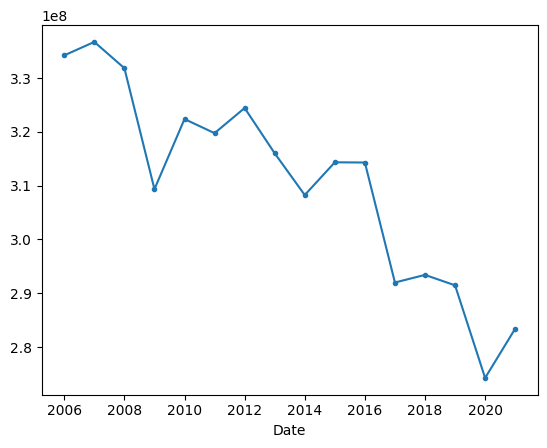

In [48]:
sums_by_year.plot(style='.-')

It is clearly in a downward trend, the scale here lets us appreciate it more, altough it may seem a bit more exacerbated by it.  
If the energy grid we are studying suplies 100% of the energy for the country, then this may be due to a decline in population. Such pattern that is presenting itself around the world, more strongly in the denominated "First World countries".  
Another hypothesis could be that another grid is suplying increasingly more power, and so the load on this one lessens.  
A third hypothesis could be Italians are becomeing more efficient in their energy use, having better insulation in their homes for example.  
I've taken the liberty to research the Italian population throghout the years and I've found this graph [source](https://www.macrotrends.net/countries/ITA/italy/population)
![italian population](./images/italian_population.png)  
  
The graph seems to lend some support to our population hypothesis, but without more extensive research it would be that any or even all three are valid (or none).  
  
Let's check compare the highest and lowest years, and percentage change to have some numbers

In [23]:
print(f"The peak of consumption was {sums_by_year.max():,.2f}MWh on {sums_by_year.idxmax()}")
print(f"The lowest consumption was {sums_by_year.min():,.2f}MWh on {sums_by_year.idxmin()}")
print(f"That represents a drop of {1-(sums_by_year.min()/sums_by_year.max()):.2%}")

The peak of consumption was 336,742,051.50MWh on 2007
The lowest consumption was 274,242,505.86MWh on 2020
That represents a drop of 18.56%


<Axes: xlabel='Date'>

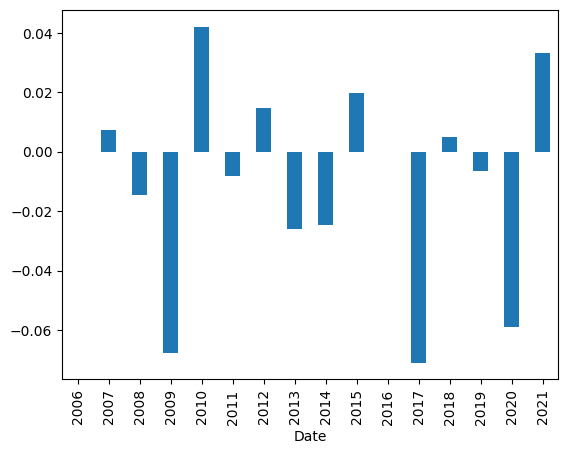

In [26]:
sums_by_year.pct_change().plot(kind='bar')

We can see here the percentual changes of each year versus the previous, we can see there are more and larger negative bars than positive ones, which results in the trend we saw

## Atypical year (2020)

We saw that 2020 has a different behaviour than the rest, we can compare with another more typical year

In [27]:
power_load_df['year'] = power_load_df.Date.dt.year
power_load_df['month_name'] = power_load_df.Date.dt.month_name()
power_load_df['day_of_year'] = power_load_df.Date.dt.day_of_year

/Users/francoferrero/anaconda3/envs/xtream/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/francoferrero/anaconda3/envs/xtream/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


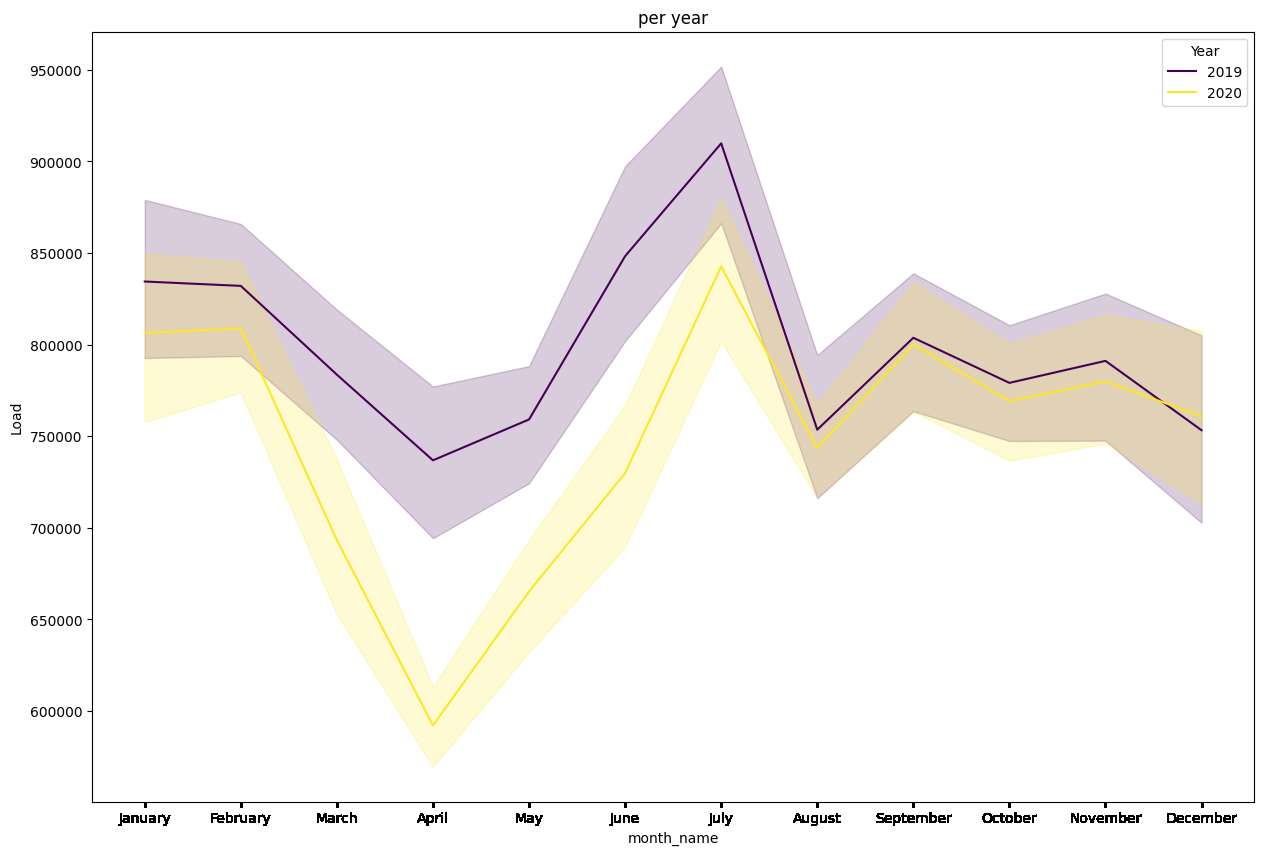

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.lineplot(data=power_load_df.query("year.isin([2019,2020])"), x='month_name', y='Load',
                  hue='year', palette='viridis')
ax.figure.set_size_inches(15, 10)
ax.set_xticks(power_load_df.month_name)
ax.set_title('per year')
ax.legend(ax.lines, power_load_df.query("year.isin([2019,2020])").year.unique(), title='Year')
# plt.legend(loc='right')
plt.show()


We see that is normally a lull in the year from March to May, is severely more pronounced. This is likely due to pandemic lockdowns, which happened across the globe.

## Normal behaviour

Let's look at a single year to see what behaviour we can find

<Axes: xlabel='month_name'>

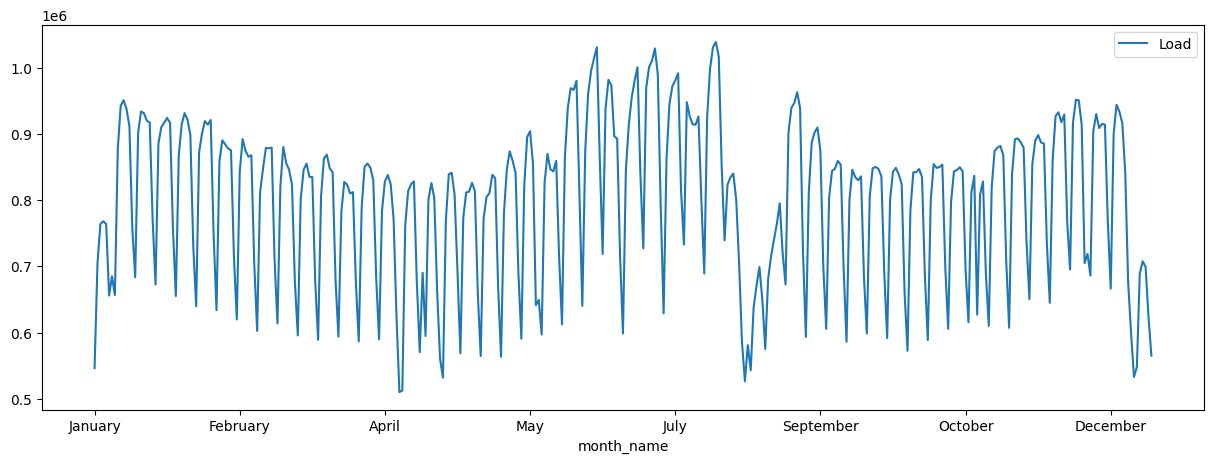

In [88]:
power_load_df.query("year==2017").plot(x='month_name',y='Load',figsize=(15,5), kind='line')

We see that we have repeating zigzags throughout the year. Those are likely weekly consumption spike and valleys. We'll some more into that later.  
  
We can also see certain sections of the series that likely coincide with the seasons of the year.  
- Winter (December to February) seems somewhat stable, if slightly decreasing as the cold becomes less harsh. One would assume a large portion of the heating needed comes from gas or some other fossil fuel, external to our energy grid, so the consumption isn't that large.  
- Spring (March to May) sees a decrease, there is less need for climate control when the weather is pleasant.  
- Summer (June to August) sees an upward trend and the peak consumption of the year. We can only cool our homes and businesses with electricity, and so everyone turns on air conditioning and consumes more, so it makes sense.  
- Autumn (September to November) again sees low-ish levels as climate is again fair.  
  
We can try to extract that behaviour from the series and see it separately if we want to, with less noise

<Axes: xlabel='month,month_name'>

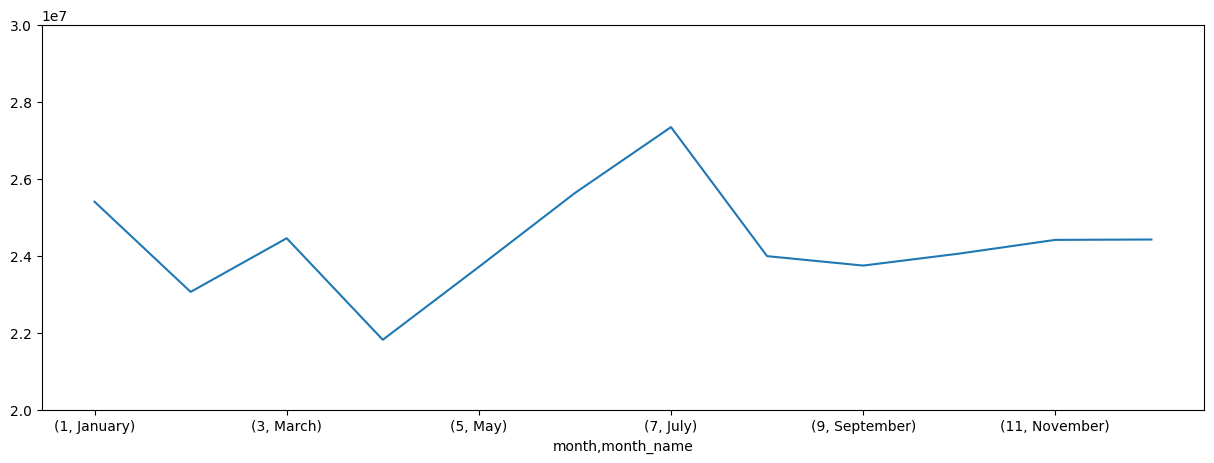

In [94]:
power_load_df.query("year==2017").groupby(['month','month_name']).Load.sum().plot(
    x='month_name',y='Load',figsize=(15,5), kind='line',ylim=(20000000,30000000)
)

### Valleys analysis

Another thing that is apparent, is that there are certain big drops in our series, mainly at the beginning/end of the year, and in August. We'll investigate this further with a look at the monthly behaviour. We'll average all years' months to show that the behaviour is consistent

In [32]:
power_load_df['day_of_week'] = power_load_df.Date.dt.day_of_week
power_load_df['day'] = power_load_df.Date.dt.day
power_load_df['month'] = power_load_df.Date.dt.month
power_load_without_2020_2022_df = power_load_df.query("not year.isin([2020,2022])").copy()
mean_daily_loads_by_month = power_load_without_2020_2022_df.groupby(['month_name','day']).Load.mean().reset_index()

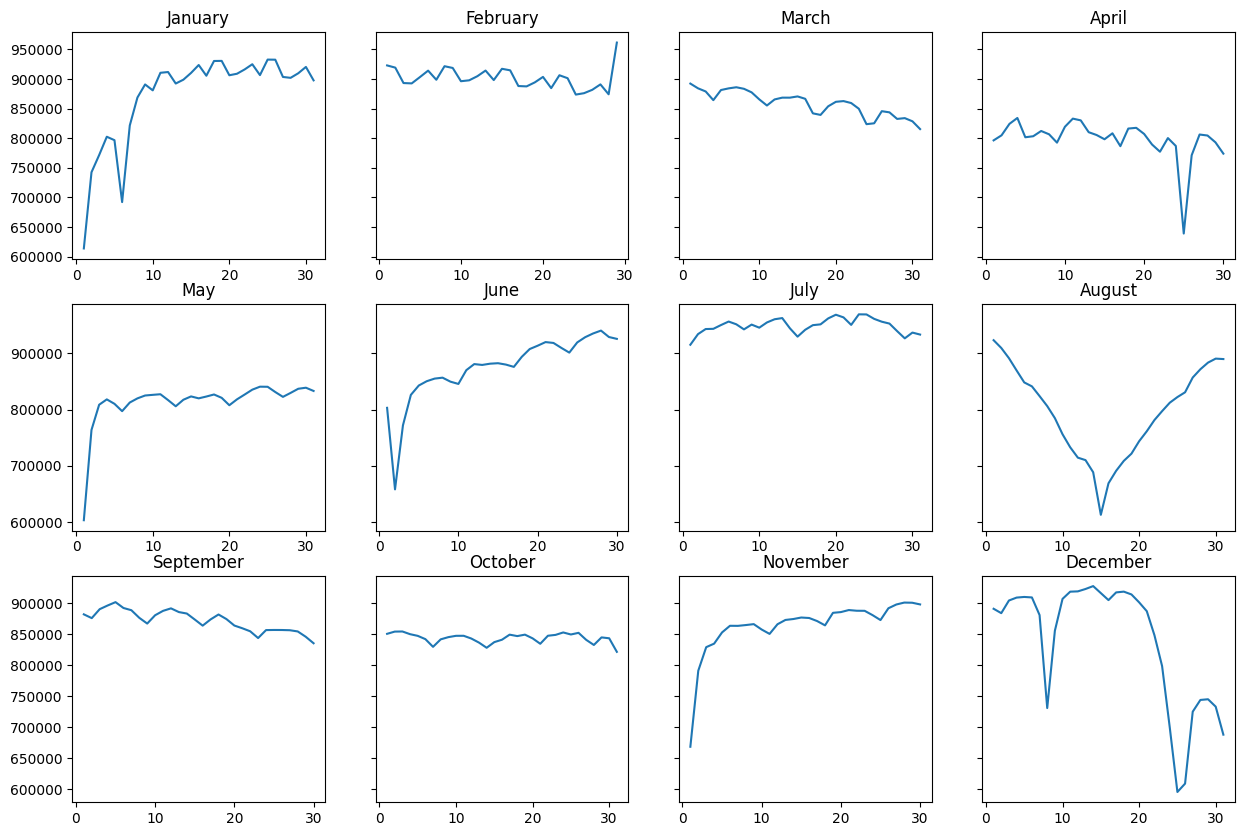

In [33]:
figure, axis = plt.subplots(3, 4, sharey='row')
figure.set_size_inches(15,10)
axi = {
    0:(0,0),1:(0,1),2:(0,2),3:(0,3),
    4:(1,0),5:(1,1),6:(1,2),7:(1,3),
    8:(2,0),9:(2,1),10:(2,2),11:(2,3)
} 
for month_nbr, month_name in enumerate(power_load_df.month_name.unique()):
    axis[axi[month_nbr]].plot(
        mean_daily_loads_by_month.query("month_name==@month_name").day,
        mean_daily_loads_by_month.query("month_name==@month_name").Load,
        # kind='line',
        # legend=False,
    ) 
    axis[axi[month_nbr]].set_title(month_name)
    axis[axi[month_nbr]].ylim=(500000,1200000)


Here We get a better sense of the days the dips occur, which if we look up an [Italian holiday's calendar](https://en.wikipedia.org/wiki/Public_holidays_in_Italy), they match up pretty nicely  
- January 1st (and shared with December 31st) -> Capodanno  
- January 6th -> Epifania
- April 25th -> Festa della Liberazione
- May 1st -> Festa del Lavoro
- June 2nd -> Festa della Repubblica
- August 15th -> Assunzione(Ferragosto)
- November 1st -> Tutti i santi
- December 8th -> Immacolata Concezione
- December 25th -> Natale  
  
I believe this hints that the largest consumers of the network are businesses and other types of companies or industries rather than normal people's homes, since in a holiday shops may close but everyone is in their homes, so those would consume more than usual.

### Weekly behaviour

Now we'll look at those weekly zigzags

In [34]:
power_load_without_2020_2022_df['day_of_week_name'] = power_load_without_2020_2022_df.Date.dt.day_name()
mean_daily_loads_by_week = power_load_without_2020_2022_df.groupby(['day_of_week','day_of_week_name']).Load.mean().reset_index()

<Axes: xlabel='day_of_week_name'>

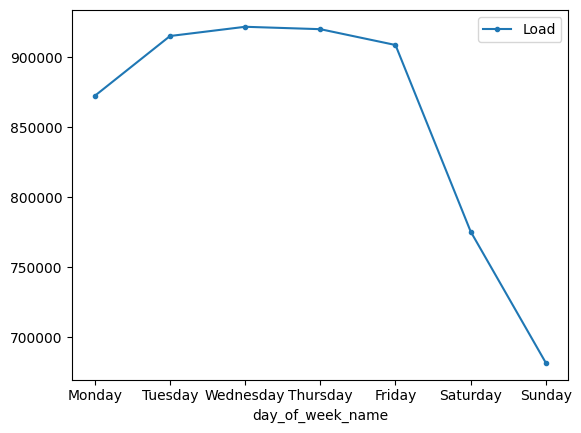

In [35]:
mean_daily_loads_by_week.plot(x='day_of_week_name',y='Load',style='.-')

Here we see that energy consumption drastically drops on saturdays, and even more on Sundays. And keep in mind that this graph represents an average week across all years, throughout the years, so it is a consistent behaviour. It lends more support to the theory that the network's largest consumers aren't people's homes. Let's put it into numbers like we did with the trend

In [38]:
peak_weekly_consumption = mean_daily_loads_by_week.Load.max()
lowest_weekly_consumption = mean_daily_loads_by_week.Load.min()

In [45]:
print("The peak of consumption is {:,.2f}MWh on {}".format(
    peak_weekly_consumption,
    mean_daily_loads_by_week.query("Load==@peak_weekly_consumption").day_of_week_name.values[0]))
print("The lowest consumption was {:,.2f}MWh on {}".format(
    lowest_weekly_consumption,
    mean_daily_loads_by_week.query("Load==@lowest_weekly_consumption").day_of_week_name.values[0]))
print(f"That represents a drop of {1-(lowest_weekly_consumption/peak_weekly_consumption):.2%}")

The peak of consumption is 921,807.51MWh on Wednesday
The lowest consumption was 681,756.03MWh on Sunday
That represents a drop of 26.04%


<Axes: >

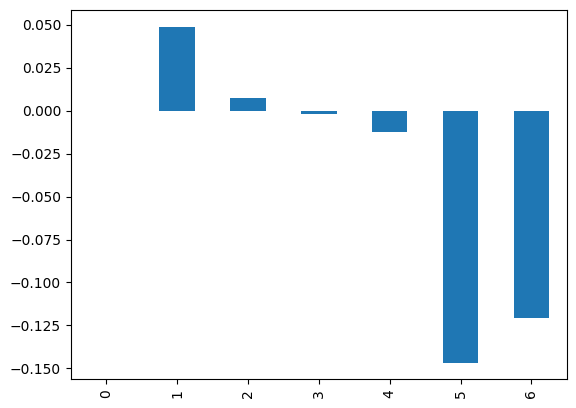

In [47]:
mean_daily_loads_by_week.Load.pct_change().plot(kind='bar')

We can see Tuesdays are 5% higher than Mondays, and then Saturday is about 15% lower than Friday, and then Sunday is around 12% lower than Saturday still  
Let's see how it looks throughout a month

<Axes: xlabel='day_of_week_name'>

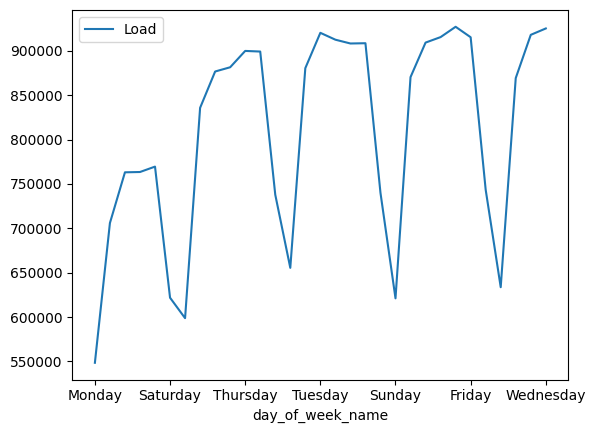

In [49]:
power_load_without_2020_2022_df.query("year==2018 and month==1").plot(x='day_of_week_name',y='Load')

## Wraping up

That's pretty much it! We've analyzed our timeseries, and gotten insights on weekly behaviours, seasonal behaviours, atypical years, the impact of holidays, the overall trend, and some hypothesis some of these points as well!